In [1]:
!pip install -Uqq fastbook
import fastbook
try:
  fastbook.setup_book()
except:
  pass

     |████████████████████████████████| 727kB 9.4MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 194kB 17.3MB/s 
     |████████████████████████████████| 1.1MB 19.6MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 40kB 6.0MB/s 
     |████████████████████████████████| 92kB 11.1MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 2.6MB 30.6MB/s 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:



In [2]:
from fastbook import *

The class activation map (CAM) was introduced by Bolei Zhou et al. in ["Learning Deep Features for Discriminative Localization"](https://arxiv.org/abs/1512.04150). It uses the output of the last convolutional layer (just before the average pooling layer) together with the predictions to give us a heatmap visualization of why the model made its decision. This is a useful tool for interpretation.


e're going to need a way to get access to the activations inside the model while it's training. In PyTorch this can be done with a *hook*. Hooks are PyTorch's equivalent of fastai's callbacks. However, rather than allowing you to inject code into the training loop like a fastai `Learner` callback, hooks allow you to inject code into the forward and backward calculations themselves. We can attach a hook to any layer of the model, and it will be executed when we compute the outputs (forward hook) or during backpropagation (backward hook). A forward hook is a function that takes three things—a module, its input, and its output—and it can perform any behavior you want. (fastai also provides a handy `HookCallback` that we won't cover here, but take a look at the fastai docs; it makes working with hooks a little easier.)


In [3]:
path = untar_data(URLs.PETS)/'images'

def is_cat(x):
  return x[0].isupper()

dls = ImageDataLoaders.from_name_func(path, get_image_files(path), valid_pct=0.2, seed=21,
                                      label_func=is_cat, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.141711,0.034602,0.010825,00:50


epoch,train_loss,valid_loss,error_rate,time
0,0.044389,0.032435,0.008796,00:55


In [9]:
img = PILImage.create(image_cat())
x, = first(dls.test_dl([img]))

In [10]:
class Hook():
  def hook_func(self, m, i, o):
    self.stored = o.detach().clone()
  

In [11]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [12]:
with torch.no_grad():
  output = learn.model.eval()(x)

In [13]:
act = hook_output.stored[0]


In [15]:
F.softmax(output, dim=-1)

TensorImage([[3.4251e-07, 1.0000e+00]], device='cuda:0')

In [14]:
dls.vocab

[False, True]

In [16]:
x.shape

torch.Size([1, 3, 224, 224])

In [18]:
cam_map = torch.einsum('ck, kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 7, 7])

For each image in our batch, and for each class, we get a 7×7 feature map that tells us where the activations were higher and where they were lower. This will let us see which areas of the pictures influenced the model's decision.

For instance, we can find out which areas made the model decide this animal was a cat (note that we need to `decode` the input `x` since it's been normalized by the `DataLoader`, and we need to cast to `TensorImage` since at the time this book is written PyTorch does not maintain types when indexing—this may be fixed by the time you are reading this):

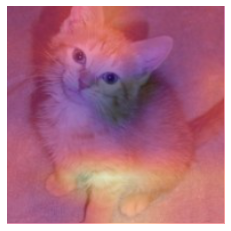

In [19]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
           interpolation='bilinear',cmap='magma')

In [20]:
hook.remove()

In [21]:
class Hook():
  def __init__(self, m):
    self.hook = m.register_forward_hook(self.hook_func)
  def hook_func(self, m, i, o):
    self.stored = o.detach().clone()
  
  def __enter__(self, *args):
    return self
  
  def __exit__(self, *args):
    self.hook.remove()

In [22]:
with Hook(learn.model[0]) as hook:
  with torch.no_grad():
    output = learn.model.eval()(x.cuda())
  act = hook.stored

## Gradient CAM

The method we just saw only lets us compute a heatmap with the last activations, since once we have our features, we have to multiply them by the last weight matrix. This won't work for inner layers in the network. A variant introduced in the paper ["Grad-CAM: Why Did You Say That? Visual Explanations from Deep Networks via Gradient-based Localization"](https://arxiv.org/abs/1611.07450) in 2016 uses the gradients of the final activation for the desired class. If you remember a little bit about the backward pass, the gradients of the output of the last layer with respect to the input of that layer are equal to the layer weights, since it is a linear layer.

With deeper layers, we still want the gradients, but they won't just be equal to the weights anymore. We have to calculate them. The gradients of every layer are calculated for us by PyTorch during the backward pass, but they're not stored (except for tensors where `requires_grad` is `True`). We can, however, register a hook on the backward pass, which PyTorch will give the gradients to as a parameter, so we can store them there. For this we will use a `HookBwd` class that works like `Hook`, but intercepts and stores gradients instead of activations:


In [25]:
class HookBwd():
  def __init__(self,m):
    self.hook = m.register_backward_hook(self.hook_func)
  
  def hook_func(self, m,gi, go):
    self.stored = go[0].detach().clone()
  
  def __enter__(self, *args): return self

  def __exit__(self, *args):
    self.hook.remove()


In [26]:
cls =1
with HookBwd(learn.model[0]) as hookg:
  with Hook(learn.model[0]) as hook:
    output = learn.model.eval()(x.cuda())
    act = hook.stored
  output[0, cls].backward()
  grad = hookg.stored
  

In [27]:
  w = grad[0].mean(dim=[1,2], keepdim=True)
  cam_map = (w * act[0]).sum(0)

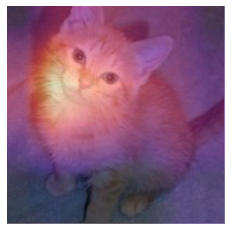

In [28]:
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0), interpolation='bilinear', cmap='magma')

In [29]:
with HookBwd(learn.model[0][-2]) as hookg:
  with Hook(learn.model[0][-2]) as hook:
    output = learn.model.eval()(x.cuda())
    act = hook.stored
  output[0, cls].backward()
  grad = hookg.stored

In [30]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

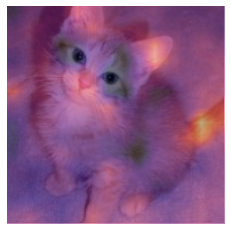

In [31]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
          interpolation='bilinear', cmap='magma')

Model interpretation is an area of active research, and we just scraped the surface of what is possible in this brief chapter. Class activation maps give us insight into why a model predicted a certain result by showing the areas of the images that were most responsible for a given prediction. This can help us analyze false positives and figure out what kind of data is missing in our training to avoid them.